In [2]:
# from IPython.display import HTML, clear_output

import brax
from datetime import datetime

from brax import envs
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import jax
import os
import json

# if 'COLAB_TPU_ADDR' in os.environ:
#   from jax.tools import colab_tpu
#   colab_tpu.setup_tpu()

In [3]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import functools
import optax
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [4]:
seed = 0
rng = jax.random.PRNGKey(seed)

env_name = 'ant'
backend = 'positional'

save_path = f'./data/{env_name}'

In [4]:
def save_trajectories(trajectories, save_path):
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  save_path = f"{save_path}/trajectories.json"
  with open(save_path, "w") as f:
    json.dump(trajectories, f)


def random_inference_fn(usize):
  def inference_fn(obs, rng):
    act = jax.random.uniform(rng, shape=(usize,), minval=-1., maxval=1.)
    return act, None
  return inference_fn


def zero_inference_fn(usize):
  def inference_fn(obs, rng):
    return jnp.zeros(usize), None
  return inference_fn


def normal_inference_fn(usize, expert_inference):
  def inference_fn(obs, rng):
    rng_1, rng_2 = jax.random.split(rng)
    act_mean, _ = expert_inference(obs, rng_1)
    act = act_mean + jax.random.normal(rng_2, shape=(usize,))
    return act, None
  return inference_fn


def collect_trajectories(rng, env, inference_fn, inference_name, save_path):
  jit_env_reset = jax.jit(env.reset)
  jit_env_step = jax.jit(env.step)
  jit_inference_fn = jax.jit(inference_fn)

  trajectories = []
  for ep in range(50):
    traj = {'states': [], 'actions': [], 'reward': 0.}
    rng, state_rng, sub_rng = jax.random.split(rng, 3)
    rwd = 0
    state = jit_env_reset(rng=state_rng)
    for _ in range(1000):
      sub_rng, act_rng = jax.random.split(sub_rng)
      act, _ = jit_inference_fn(state.obs, act_rng)

      traj['states'].append(state.obs.tolist())
      traj['actions'].append(act.tolist())

      state = jit_env_step(state, act)
      rwd += state.reward

    traj['reward'] = float(rwd)
    trajectories.append(traj)

  save_path = f"{save_path}/{inference_name}"
  save_trajectories(trajectories, save_path)


#### Train expert policy

In [5]:
# See: https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb

train_fn = {
  'halfcheetah': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'ant': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
}[env_name]

In [6]:
max_y = {'halfcheetah': 8000, 'walker2d': 5000, 'hopper': 2500, 'ant': 8000}[env_name]
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

In [7]:
env = envs.get_environment(env_name=env_name, backend=backend)

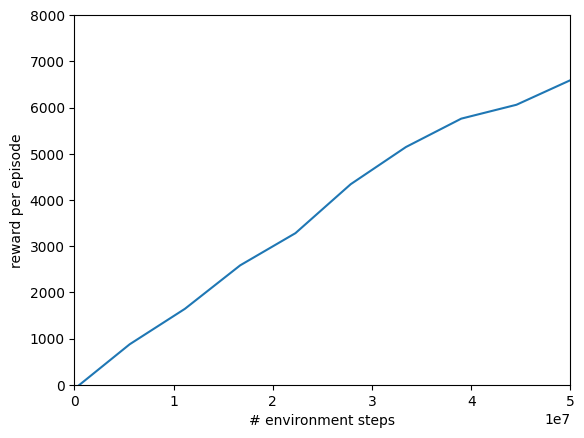

time to jit: 0:00:47.919114
time to train: 0:07:28.499283


In [8]:
make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

#### Collect trajectories

In [9]:
inference_env = envs.create(env_name=env_name, backend=backend)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
expert_inference = make_inference_fn(params)
usize = inference_env.action_size

In [ ]:
rng_1, rng_2, rng_3, rng_4 = jax.random.split(rng, 4)
inf_fn_and_name = [
    (expert_inference, 'expert', rng_1),
    (random_inference_fn(usize), 'random', rng_2),
    (zero_inference_fn(usize), 'zero', rng_3),
    (normal_inference_fn(usize, expert_inference), 'normal', rng_4),
]


for fn, name, rng_key in inf_fn_and_name:
  print(f"Trajectory collecting for: {name}")
  collect_trajectories(
      rng=rng_key,
      env=inference_env,
      inference_fn=fn,
      inference_name=name,
      save_path=save_path
  )

Trajectory collecting for: expert
Trajectory collecting for: random
Trajectory collecting for: zero
